In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [2]:
# Read the data
data = pd.read_csv('../data/all_data.csv')

print(data.shape)

# Display the first few rows of the updated dataframe
data.head()

(130000, 318)


,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn,Ja,Nee,checked
0,1,1,0,0,23240,1,0,0,0,0,...,1,0,0,0,0,0,0,0.617698,0.382302,False
1,4,2,1,1,1971,1,0,0,1,0,...,1,0,1,0,1,0,0,0.602167,0.397833,False
2,6,4,2,1,7247,0,0,0,1,0,...,1,0,1,0,0,0,0,0.512377,0.487623,False
3,3,2,0,1,8060,1,0,0,1,0,...,1,0,0,0,0,0,0,0.717796,0.282204,True
4,3,2,0,0,18705,1,0,0,0,0,...,1,0,1,0,0,0,0,0.705484,0.294516,True


In [3]:
# Define bins and labels for categorization
bins = [17, 25, 45, 67]
labels = ['18-25', '25-45', '45-67']

In [4]:
# Let's specify the features and the target
y = data['checked']
X = data.drop(['checked', 'Ja', 'Nee'], axis=1)
X = X.astype(np.float32)

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=None
)

In [5]:
# Bin the age column in the training data
train_age_groups = pd.cut(
    X_train['persoon_leeftijd_bij_onderzoek'],
    bins=bins,
    labels=labels
)

# Calculate the current distribution of age groups in the training set
current_counts = train_age_groups.value_counts().sort_index()
current_proportions = current_counts / current_counts.sum()

# Real distribution counts
real_distr = np.array([92793, 211801, 159292])

# Calculate the desired proportions based on real distribution
desired_proportions = real_distr / real_distr.sum()

# Create a mapping from age group to desired weight
weight_mapping = desired_proportions / current_proportions

weight_mapping = pd.Series(weight_mapping, index=labels).to_dict()

# Assign weights to each sample in the training set based on its age group
sample_weights = train_age_groups.map(weight_mapping)

In [6]:
# Define a Logistic Regression classifier
classifier = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='sag',
    max_iter=25000,
    random_state=42
)

# Create a pipeline with the classifier
pipeline = Pipeline([('classifier', classifier)])

In [7]:
# Fit the pipeline with sample weights
pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)

# Predict on the test set
y_pred = pipeline.predict(X_test)

In [10]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy: {:.2f}%'.format(accuracy * 100))

Model accuracy: 85.36%


Top Features by Coefficient Magnitude:
                                               Feature  Coefficient
165                contacten_soort_document__uitgaand_     0.015625
216                     persoon_leeftijd_bij_onderzoek    -0.010413
286   relatie_kind_leeftijd_verschil_ouder_eerste_kind     0.007812
155  contacten_soort_afgelopenjaar_document__uitgaand_     0.007812
179              instrument_ladder_historie_activering    -0.003906
47                    afspraak_signaal_voor_medewerker    -0.003906
138                       contacten_onderwerp_matching     0.003906
140                        contacten_onderwerp_no_show     0.003906
163                             contacten_soort_anders     0.003906
166                  contacten_soort_e_mail__inkomend_     0.003906


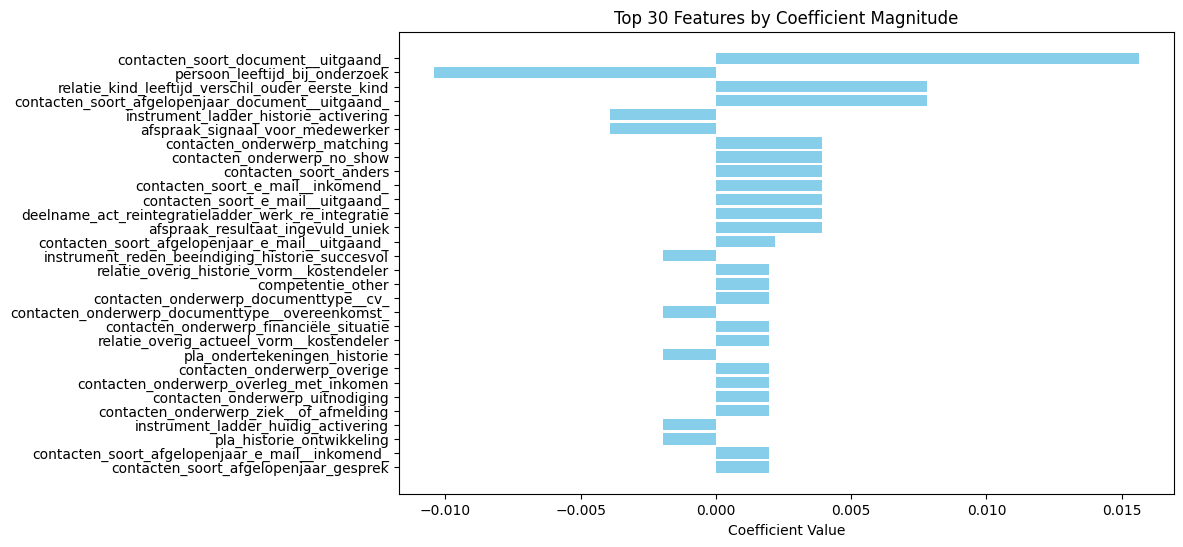

In [11]:
# After fitting the pipeline...

# Step 1: Access the trained logistic regression model from the pipeline
trained_model = pipeline.named_steps['classifier']

# Step 2: Extract the coefficients
# For binary classification, coef_ is of shape (1, n_features)
coefficients = trained_model.coef_[0]

# Step 3: Get the feature names
feature_names = X.columns

# Create a DataFrame mapping feature names to their coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Calculate the absolute value of coefficients for sorting
feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()

# Sort the DataFrame by absolute coefficient in descending order
feature_importance_sorted = feature_importance.sort_values(
    by='Absolute Coefficient', ascending=False
)

# Display the top features
print("Top Features by Coefficient Magnitude:")
print(feature_importance_sorted[['Feature', 'Coefficient']].head(10))

# Optional: Visualize the top 10 features
top_n = 30
top_features = feature_importance_sorted.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'][::-1], top_features['Coefficient'][::-1], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title(f'Top {top_n} Features by Coefficient Magnitude')
plt.show()